In [219]:
%matplotlib inline
# %matplotlib notebook

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [220]:
# ścieżki do plików
f_o2022 = r"C:\SEM6\SISS\metadata\ortophoto\sk_orto_2022.gpkg"
f_o2021 = r"C:\SEM6\SISS\metadata\ortophoto\sk_orto_2021.gpkg"
f_o2020 = r"C:\SEM6\SISS\metadata\ortophoto\sk_orto_2020.gpkg"
f_o2019 = r"C:\SEM6\SISS\metadata\ortophoto\sk_orto_2019.gpkg"
f_o2018 = r"C:\SEM6\SISS\metadata\ortophoto\sk_orto_2018.gpkg"

f_l2022 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_evrf_2022.gpkg"
f_l2021 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_evrf_2021.gpkg"
f_l2020 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_evrf_2020.gpkg"
f_l2019 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_evrf_2019.gpkg"
f_l2018 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_evrf_2018.gpkg"

f_lk2019 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_kron_2019.gpkg"
f_lk2018 = r"C:\SEM6\SISS\metadata\lidar\sk_lidar_kron_2018.gpkg"


# ORTO

In [221]:
# dictionary, aby móc łatwo się odwoływać do dataframeów
orto = {
2022: gpd.read_file(f_o2022),
2021: gpd.read_file(f_o2021),
2020: gpd.read_file(f_o2020),
2019: gpd.read_file(f_o2019),
2018: gpd.read_file(f_o2018),
}

for year in orto.keys():
    # pozbycie się niepotrzebnych kolumn
    orto[year].drop(columns=['gml_id','nr_zglosz', 'akt_rok', 'zrodlo_danych'], inplace=True)
    # zamiana typu daty zrobienia zdjęcia (?) na datetime
    orto[year]['timePosition'] = pd.to_datetime(orto[year]['timePosition'])

# LIDAR

In [222]:
# dictionary, aby móc łatwo się odwoływać do dataframeów
lidar = {
2022: gpd.read_file(f_l2022),
2021: gpd.read_file(f_l2021),
2020: gpd.read_file(f_l2020),
2019: gpd.read_file(f_l2019),
2018: gpd.read_file(f_l2018),
}

lidar_kron = {
2019: gpd.read_file(f_lk2019),
2018: gpd.read_file(f_lk2018),
}

for year in lidar.keys():
    # pozbycie się niepotrzebnych kolumn
    lidar[year].drop(columns=['zrodlo_danych', 'blad_sr_wys', 'nr_zglosz', 'uklad_h', 'asortyment', 'gml_id', 'akt_rok', 'format',], inplace=True)
    # zamiana typu daty zrobienia skaningu
    lidar[year]['timePosition'] = pd.to_datetime(lidar[year]['timePosition'])

for year in lidar_kron.keys():
    # pozbycie się niepotrzebnych kolumn
    lidar_kron[year].drop(columns=['zrodlo_danych', 'blad_sr_wys', 'nr_zglosz', 'uklad_h', 'asortyment', 'gml_id', 'akt_rok', 'format',], inplace=True)
    # zamiana typu daty zrobienia skaningu
    lidar_kron[year]['timePosition'] = pd.to_datetime(lidar_kron[year]['timePosition'])
    

# SJOIN, czyli łączenie ORTO i LIDAR

In [223]:
giga_df = pd.DataFrame()
for year in lidar.keys():
    # spatial join - przyłączamy dane o orto do danych o lidar (zostaje geometria arkuszy lidar)
    temp_df = lidar[year].sjoin(orto[year], how="left", lsuffix='lidar', rsuffix='orto', predicate='within')
    temp_df.dropna(inplace=True)
    # nowa kolumna z różnicą czasu od wykonania zdjęcia do czasu wykonania skaningu, np. -10days oznacza, że zdjęcie zrobione 10 dni wcześniej niż skanowanie laserowe
    temp_df['time_diff'] = temp_df['timePosition_orto'] - temp_df['timePosition_lidar']
    # połączenie danych z różnych lat w jeden duży dataframe
    giga_df = pd.concat([temp_df, giga_df], axis=0, ignore_index=True)

for year in lidar_kron.keys():
    # spatial join - przyłączamy dane o orto do danych o lidar (zostaje geometria arkuszy lidar)
    temp_df = lidar_kron[year].sjoin(orto[year], how="left", lsuffix='lidar', rsuffix='orto', predicate='within')
    temp_df.dropna(inplace=True)
    # nowa kolumna z różnicą czasu od wykonania zdjęcia do czasu wykonania skaningu, np. -10days oznacza, że zdjęcie zrobione 10 dni wcześniej niż skanowanie laserowe
    temp_df['time_diff'] = temp_df['timePosition_orto'] - temp_df['timePosition_lidar']
    # połączenie danych z różnych lat w jeden duży dataframe
    giga_df = pd.concat([temp_df, giga_df], axis=0, ignore_index=True)

In [224]:
giga_df

,godlo_lidar,char_przestrz,uklad_xy_lidar,modul_archiwizacji_lidar,timePosition_lidar,czy_ark_wypelniony_lidar,url_do_pobrania_lidar,geometry,index_orto,godlo_orto,piksel,kolor,uklad_xy_orto,modul_archiwizacji_orto,timePosition_orto,czy_ark_wypelniony_orto,url_do_pobrania_orto,wlk_pliku_MB,time_diff
0,N-34-97-C-b-3-3-2-1,12 p/m2,PL-1992,1:1250,2018-03-17,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((442999.770 581852.040, 442476.850 58...",19677.0,N-34-97-C-b-3-3,0.07,RGB,PL-1992,1:5000,2018-04-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,544.0,33 days
1,N-34-97-C-b-3-3-2-2,12 p/m2,PL-1992,1:1250,2018-03-17,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((443522.700 581845.850, 442999.770 58...",19677.0,N-34-97-C-b-3-3,0.07,RGB,PL-1992,1:5000,2018-04-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,544.0,33 days
2,N-34-97-C-b-3-3-2-2,12 p/m2,PL-1992,1:1250,2018-03-17,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((443522.700 581845.850, 442999.770 58...",20648.0,6.193.22.22,0.07,RGB,PL-2000:S6,1:2000,2018-04-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,173.0,33 days
3,N-34-97-C-d-1-3-4-3,12 p/m2,PL-1992,1:1250,2018-03-17,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((442924.070 575480.700, 442400.450 57...",20046.0,N-34-97-C-d-1-3,0.07,RGB,PL-1992,1:5000,2018-04-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,612.0,33 days
4,N-34-97-C-c-2-1-1-2,12 p/m2,PL-1992,1:1250,2018-03-17,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((438263.630 579593.430, 437740.460 57...",19815.0,N-34-97-C-c-2-1,0.07,RGB,PL-1992,1:5000,2018-04-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,565.0,33 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147804,6.198.12.04.2,15 p/m2,PL-2000:S6,1:1000,2022-07-21,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((367114.578 612210.375, 367121.578 61...",16750.0,N-33-95-C-c-3-1,0.05,RGB,PL-1992,1:5000,2022-05-17,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,1015.0,-65 days
147805,6.199.13.21.2,15 p/m2,PL-2000:S6,1:1000,2022-07-21,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((370326.784 613165.009, 370333.785 61...",16746.0,N-33-95-C-c-3-2,0.05,RGB,PL-1992,1:5000,2022-05-17,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,1017.0,-65 days
147806,6.198.13.01.1,15 p/m2,PL-2000:S6,1:1000,2022-07-21,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((369513.233 612176.773, 369520.233 61...",16746.0,N-33-95-C-c-3-2,0.05,RGB,PL-1992,1:5000,2022-05-17,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,1017.0,-65 days
147807,6.199.12.24.4,15 p/m2,PL-2000:S6,1:1000,2022-07-21,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((367121.578 612710.096, 367128.579 61...",16750.0,N-33-95-C-c-3-1,0.05,RGB,PL-1992,1:5000,2022-05-17,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,1015.0,-65 days


# Co dalej? Jak żyć?

In [270]:
mask = (giga_df['piksel']==0.25) & (giga_df['kolor']=='RGB') & (abs(giga_df['time_diff'])<=pd.Timedelta(days=9))
chosen_df = giga_df[mask].copy().reset_index(drop=True)
chosen_df

,godlo_lidar,char_przestrz,uklad_xy_lidar,modul_archiwizacji_lidar,timePosition_lidar,czy_ark_wypelniony_lidar,url_do_pobrania_lidar,geometry,index_orto,godlo_orto,piksel,kolor,uklad_xy_orto,modul_archiwizacji_orto,timePosition_orto,czy_ark_wypelniony_orto,url_do_pobrania_orto,wlk_pliku_MB,time_diff
0,M-33-48-A-a-1-1-1,4 p/m2,PL-1992,1:2500,2019-03-30,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((394767.900 348620.720, 394779.680 34...",2415.0,M-33-48-A-a-1-1,0.25,RGB,PL-1992,1:5000,2019-04-02,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,39.0,3 days
1,M-33-47-A-c-2-4-1,4 p/m2,PL-1992,1:2500,2019-03-30,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((365970.230 337700.450, 365985.180 33...",3944.0,M-33-47-A-c-2-4,0.25,RGB,PL-1992,1:5000,2019-04-02,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,31.0,3 days
2,M-33-46-B-b-2-2-4,4 p/m2,PL-1992,1:2500,2019-03-30,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((358565.390 348325.530, 358581.220 34...",2979.0,M-33-46-B-b-2-2,0.25,RGB,PL-1992,1:5000,2019-04-02,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,32.0,3 days
3,M-33-46-B-b-4-1-4,4 p/m2,PL-1992,1:2500,2019-03-30,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((356244.230 343754.560, 356260.290 34...",4626.0,M-33-46-B-b-4-1,0.25,RGB,PL-1992,1:5000,2019-04-02,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,29.0,3 days
4,M-33-47-A-b-3-4-3,4 p/m2,PL-1992,1:2500,2019-03-30,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((370451.120 341062.490, 370465.590 34...",2463.0,M-33-47-A-b-3-4,0.25,RGB,PL-1992,1:5000,2019-04-02,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,34.0,3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14094,7.117.27.05.4,25 p/m2,PL-2000:S7,1:1000,2022-05-12,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((699289.795 208956.700, 699276.478 20...",28450.0,M-34-80-D-c-1-3,0.25,RGB,PL-1992,1:5000,2022-05-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,48.0,7 days
14095,7.117.27.07.1,25 p/m2,PL-2000:S7,1:1000,2022-05-12,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((693706.117 208307.837, 693692.802 20...",26296.0,M-34-80-C-d-2-3,0.25,RGB,PL-1992,1:5000,2022-05-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,53.0,7 days
14096,7.117.27.22.4,25 p/m2,PL-2000:S7,1:1000,2022-05-12,NIE,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((694598.862 204831.043, 694585.553 20...",26119.0,M-34-80-C-d-4-3,0.25,RGB,PL-1992,1:5000,2022-05-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,53.0,7 days
14097,7.117.28.16.4,25 p/m2,PL-2000:S7,1:1000,2022-05-12,TAK,https://opendata.geoportal.gov.pl/NumDaneWys/D...,"POLYGON ((700968.837 206000.875, 700955.526 20...",28565.0,M-34-80-D-c-3-2,0.25,RGB,PL-1992,1:5000,2022-05-19,TAK,https://opendata.geoportal.gov.pl/ortofotomapa...,49.0,7 days


In [260]:
chosen_df.nunique()

godlo_lidar                 10944
char_przestrz                   3
uklad_xy_lidar                  2
modul_archiwizacji_lidar        3
timePosition_lidar             32
czy_ark_wypelniony_lidar        2
url_do_pobrania_lidar       10944
geometry                    10944
index_orto                   1719
godlo_orto                   1727
piksel                          1
kolor                           1
uklad_xy_orto                   1
modul_archiwizacji_orto         1
timePosition_orto              20
czy_ark_wypelniony_orto         1
url_do_pobrania_orto         1727
wlk_pliku_MB                   51
time_diff                      15
dtype: int64

In [261]:
chosen_df['url_do_pobrania_orto'].value_counts()

https://opendata.geoportal.gov.pl/ortofotomapa/72967/72967_843267_M-34-50-D-a-3-2.tif     16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949339_M-33-8-C-a-1-2.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949042_M-33-7-B-b-3-1.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73131/73131_879270_M-34-49-C-d-2-1.tif     16
https://opendata.geoportal.gov.pl/ortofotomapa/73131/73131_879267_M-34-49-C-d-2-4.tif     16
                                                                                          ..
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1054585_M-33-31-D-c-1-3.tif     1
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1054635_M-33-43-B-c-4-3.tif     1
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1053166_M-33-30-D-d-2-4.tif     1
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1052427_M-33-32-C-a-3-3.tif     1
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1052719_M-3

In [262]:
chosen_df['url_do_pobrania_orto'].value_counts().loc[chosen_df['url_do_pobrania_orto'].value_counts().values==chosen_df['url_do_pobrania_orto'].value_counts().values[0]]

https://opendata.geoportal.gov.pl/ortofotomapa/72967/72967_843267_M-34-50-D-a-3-2.tif     16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949339_M-33-8-C-a-1-2.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949042_M-33-7-B-b-3-1.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73131/73131_879270_M-34-49-C-d-2-1.tif     16
https://opendata.geoportal.gov.pl/ortofotomapa/73131/73131_879267_M-34-49-C-d-2-4.tif     16
                                                                                          ..
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1052261_M-33-21-C-d-4-1.tif    16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949256_M-33-8-A-c-4-3.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949254_M-33-8-A-c-4-1.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/73858/73858_949252_M-33-8-A-c-3-3.tif      16
https://opendata.geoportal.gov.pl/ortofotomapa/75106/75106_1055426_M-3

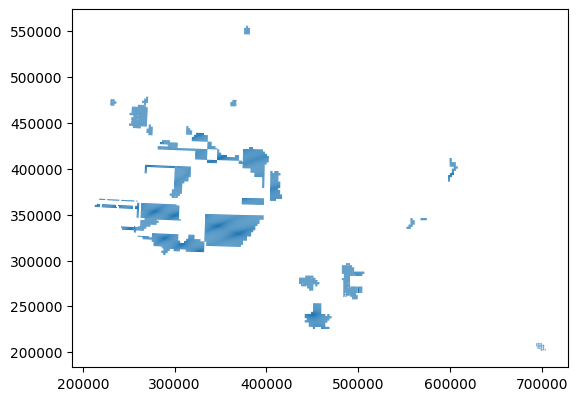

In [263]:
chosen_df.plot()
plt.show()

In [264]:
# wtf_df = chosen_df.copy()
# for name in chosen_df.columns:
#     if chosen_df[name].dtype in ['datetime64[ns]', 'timedelta64[ns]']:
#         wtf_df[name] = wtf_df[name].astype(str)

# wtf_df.to_file(r'C:\SEM6\SISS\test\lidar_test\test2geopandas.gpkg', driver='GPKG', layername='test2geopandas')

In [265]:
# wtf_df.sindex.valid_query_predicates

In [266]:
# odnośnie bdota: przed ślepym pobieraniem arkuszy, sprawdzić, czy i ile budynków znajduje się w poligonie arkuszu, wykorzystać tylko te z dużą liczbą budynków